# PV from pvlib

https://pvlib-python.readthedocs.io/en/stable/user_guide/introtutorial.html

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pvlib

from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain

### Location

In [2]:
# Vienna coordinates
latitude = 48.208
longitude = 16.3738
altitude = 172
tz = 'Europe/Vienna'

In [3]:
tilt = 30
azimuth = 180

### Module Parameters

In [4]:
# Module parameters
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
print(f"{len(sandia_modules.columns)} Modules, {len(sapm_inverters.columns)} Inverters.") 
print(sandia_modules.columns[range(10, 520, 100)])
print(sapm_inverters.columns[range(10, 3300, 1000)])

523 Modules, 3264 Inverters.
Index(['AstroPower_AP_100___2001_', 'BP_Solar_SX60__2003__E__',
       'Photowatt_PW6_110__2003__E__', 'Sharp_NE_H120E1___2001_',
       'Siemens_Solar_SR90__12V____1998_',
       'Yingli_Solar_YL230_29b_Module___2009_'],
      dtype='object')
Index(['ABB__PVI_3_0_OUTD_S_US__240V_',
       'Eoplly_New_Energy_Technology__EP156MB_60_230S_AC__240V_',
       'Power_Electronics__FS2110CU__420V_',
       'Sunna_Tech__SUNNA_3000TL_US_240__240V_'],
      dtype='object')


In [5]:
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
module.head()

Vintage              2009
Area                1.701
Material             c-Si
Cells_in_Series        96
Parallel_Strings        1
Name: Canadian_Solar_CS5P_220M___2009_, dtype: object

In [6]:
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
inverter.head()

Vac            208
Pso       2.089607
Paco         250.0
Pdco    259.588593
Vdco          40.0
Name: ABB__MICRO_0_25_I_OUTD_US_208__208V_, dtype: object

In [7]:
temperature_models = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']
print(temperature_models.keys())
temperature_model_parameters = temperature_models['open_rack_glass_glass']
temperature_model_parameters

dict_keys(['open_rack_glass_glass', 'close_mount_glass_glass', 'open_rack_glass_polymer', 'insulated_back_glass_polymer'])


{'a': -3.47, 'b': -0.0594, 'deltaT': 3}

### Weather

In [8]:
# Get weather for a measured year between 2005 and 2016,
# should alrady parse tilt and azimuth here, returns POA irradiance.
year_weather = pvlib.iotools.get_pvgis_hourly(latitude, longitude, start=2015, end=2015)[0]

In [9]:
# Get measured data for a typical year from the same dataset
# this returns components ghi, dni, dhi
tmy_weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude)[0] # Typical meteorolgical year

In [10]:
tmy_weather.index = pd.to_datetime('2015-' + tmy_weather.index.strftime('%m-%dT%H%M'))

<Axes: xlabel='time(UTC)'>

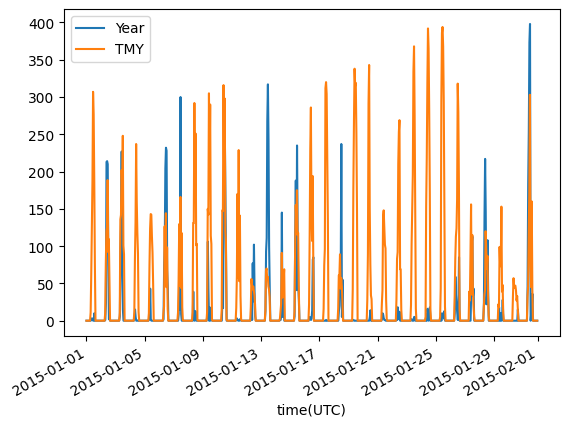

In [11]:
ax = year_weather['poa_direct']['2015-01'].plot(label='Year', legend=True)
tmy_weather['ghi']['2015-01'].plot(ax=ax, label='TMY', legend=True)

## Calculation

We are using the Object Oriented approach, as it is a bit more clear in my opinion.

In [12]:
location = Location(
    latitude,
    longitude,
    name='Vienna',
    altitude=altitude,
    tz=tz,
)


In [13]:
mount = FixedMount(surface_tilt=tilt, surface_azimuth=azimuth)
array = Array(
    mount=mount,
    module_parameters=module,
    temperature_model_parameters=temperature_model_parameters,
)
system = PVSystem(arrays=[array], inverter_parameters=inverter)

In [14]:
mc = ModelChain(system, location)
mc

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

In [15]:
mc.run_model(tmy_weather)
# mc.run_model_from_poa(year_weather) # For yearly data would have to convert to needed parameters

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

In [16]:
annual_energy = mc.results.ac.sum()
annual_energy

260974.52495910958

In [17]:
pv_gen_ts = mc.results.ac
pv_gen_ts.sample(5)

time(UTC)
2015-02-17 09:00:00    18.200732
2015-07-19 02:00:00    -0.075000
2015-01-27 22:00:00    -0.075000
2015-05-31 00:00:00    -0.075000
2015-05-26 00:00:00    -0.075000
dtype: float64

<Axes: xlabel='time(UTC)'>

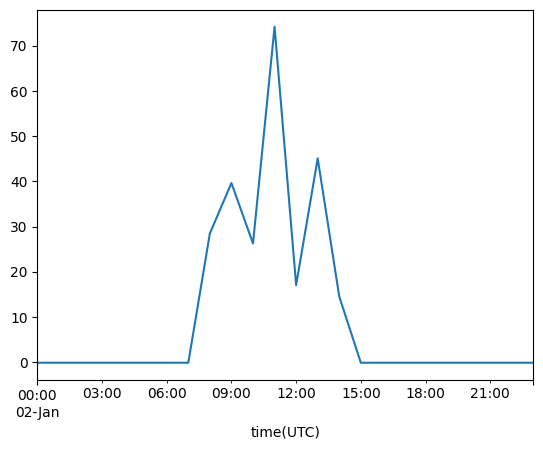

In [18]:
pv_gen_ts['2015-01-02'].plot()

<Axes: xlabel='time(UTC)'>

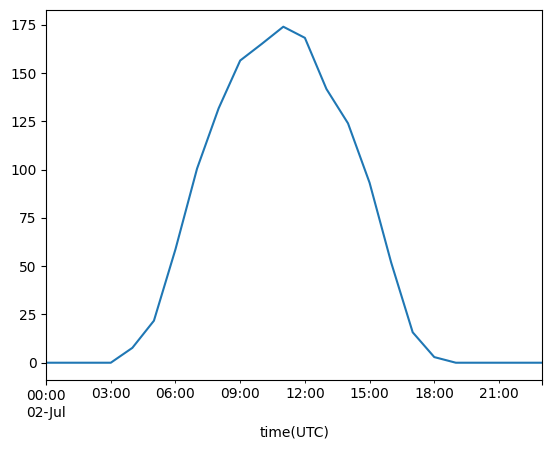

In [19]:
pv_gen_ts['2015-07-02'].plot()